# Stochastic Optimization

<div class="alert alert-info">
<b>Ce notebook a été réalisé par</b>: <br>

<li>BRASIL, Isabel</li>
<li>RAMOS, Pedro</li>

ISAE-Supaero, SD/SDD 2026
</div>

## Exercise on Control

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

Today you'll explore advanced SGD methods (momentum, Adam) and compare them with gradient-free approaches on a robotic arm control problem. You'll also learn automatic differentiation with JAX.

In [1]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import jax
import jax.numpy as jnp
from jax import grad, jit
from typing import Tuple, List, Callable
import time

# Set random seeds for reproducibility
np.random.seed(42)

# Enable JAX to run on CPU (for consistent behavior across platforms)
jax.config.update('jax_platform_name', 'cpu')

print("Setup complete! JAX version:", jax.__version__)
print("NumPy version:", np.__version__)

Setup complete! JAX version: 0.6.2
NumPy version: 2.2.6


# Exploring the Robot Arm
Run the provided visualization to understand the 2-joint planar arm. Experiment with different joint angles. We will experiment with two different libraries for this robot arm: numpy and [jax](docs.jax.dev/en/latest/index.html). Jax will enable easier gradient calculations through [automatic differentiation](https://huggingface.co/blog/andmholm/what-is-automatic-differentiation). For now, understand and explore this 2-joint robot arm which uses two angles to calculate the end position of the arm.

In [2]:
def forward_kinematics_numpy(theta: np.ndarray, lengths: np.ndarray) -> np.ndarray:
    """
    Compute end-effector position for a 2-joint planar arm.
    
    Parameters:
    -----------
    theta : np.ndarray, shape (2,)
        Joint angles [theta1, theta2] in radians
    lengths : np.ndarray, shape (2,)
        Link lengths [L1, L2]
    
    Returns:
    --------
    position : np.ndarray, shape (2,)
        End-effector position [x, y]
    """
    theta1, theta2 = theta
    L1, L2 = lengths
    
    # First joint position
    x1 = L1 * np.cos(theta1)
    y1 = L1 * np.sin(theta1)
    
    # End-effector position
    x2 = x1 + L2 * np.cos(theta1 + theta2)
    y2 = y1 + L2 * np.sin(theta1 + theta2)
    
    return np.array([x2, y2])

In [3]:
# JAX version (for automatic differentiation)
def forward_kinematics_jax(theta: jnp.ndarray, lengths: jnp.ndarray) -> jnp.ndarray:
    """
    Compute end-effector position for a 2-joint planar arm (JAX version).
    
    Parameters:
    -----------
    theta : jnp.ndarray, shape (2,)
        Joint angles [theta1, theta2] in radians
    lengths : jnp.ndarray, shape (2,)
        Link lengths [L1, L2]
    
    Returns:
    --------
    position : jnp.ndarray, shape (2,)
        End-effector position [x, y]
    """
    theta1, theta2 = theta
    L1, L2 = lengths
    
    # First joint position
    x1 = L1 * jnp.cos(theta1)
    y1 = L1 * jnp.sin(theta1)
    
    # End-effector position
    x2 = x1 + L2 * jnp.cos(theta1 + theta2)
    y2 = y1 + L2 * jnp.sin(theta1 + theta2)
    
    return jnp.array([x2, y2])

No fundo, só mudou o módulo, de `np.cos` pra `jnp.cos`, a diferença é que o jax **sabe a derivada de todas as funções q ele calcula**, ent mais tarde, na definição do gradiente, o jax vai come in handy

In [4]:
# Get all joint positions for visualization
def get_arm_points(theta: np.ndarray, lengths: np.ndarray) -> np.ndarray:
    """
    Get positions of all joints for visualization.
    
    Returns:
    --------
    points : np.ndarray, shape (3, 2)
        Positions of [base, joint1, end-effector]
    """
    theta1, theta2 = theta
    L1, L2 = lengths
    
    # Base at origin
    p0 = np.array([0.0, 0.0])
    
    # First joint
    p1 = np.array([L1 * np.cos(theta1), L1 * np.sin(theta1)])
    
    # End-effector
    p2 = p1 + np.array([L2 * np.cos(theta1 + theta2), 
                        L2 * np.sin(theta1 + theta2)])
    
    return np.array([p0, p1, p2])

In [5]:
# Test the implementations
print("Testing forward kinematics...")
test_theta = np.array([np.pi/4, np.pi/4])
test_lengths = np.array([1.0, 1.0])

pos_numpy = forward_kinematics_numpy(test_theta, test_lengths)
pos_jax = forward_kinematics_jax(test_theta, test_lengths)

print(f"NumPy result: {pos_numpy}")
print(f"JAX result: {pos_jax}")
print(f"Match: {np.allclose(pos_numpy, np.array(pos_jax))}")

Testing forward kinematics...
NumPy result: [0.70710678 1.70710678]
JAX result: [0.7071067 1.7071068]
Match: True


In [6]:
# Visualization Utilities
def plot_arm(theta: np.ndarray, lengths: np.ndarray, 
             target: np.ndarray = None, obstacles: List = None,
             ax=None, title: str = "Robot Arm"):
    """
    Plot the robot arm configuration.
    
    Parameters:
    -----------
    theta : np.ndarray
        Joint angles
    lengths : np.ndarray
        Link lengths
    target : np.ndarray, optional
        Target position to visualize
    obstacles : List of tuples, optional
        List of (x, y, radius) for circular obstacles
    ax : matplotlib axis, optional
        Axis to plot on
    title : str
        Plot title
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Get arm points
    points = get_arm_points(theta, lengths)
    
    # Plot arm links
    ax.plot(points[:, 0], points[:, 1], 'o-', linewidth=3, 
            markersize=8, label='Arm', color='blue')
    
    # Plot base
    ax.plot(0, 0, 'ks', markersize=12, label='Base')
    
    # Plot end-effector
    ax.plot(points[-1, 0], points[-1, 1], 'ro', 
            markersize=10, label='End-effector')
    
    # Plot target if provided
    if target is not None:
        ax.plot(target[0], target[1], 'g*', 
                markersize=15, label='Target')
    
    # Plot obstacles if provided
    if obstacles is not None:
        for obs in obstacles:
            circle = Circle((obs[0], obs[1]), obs[2], 
                          color='red', alpha=0.3, label='Obstacle')
            ax.add_patch(circle)
    
    # Set axis properties
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()
    
    return ax

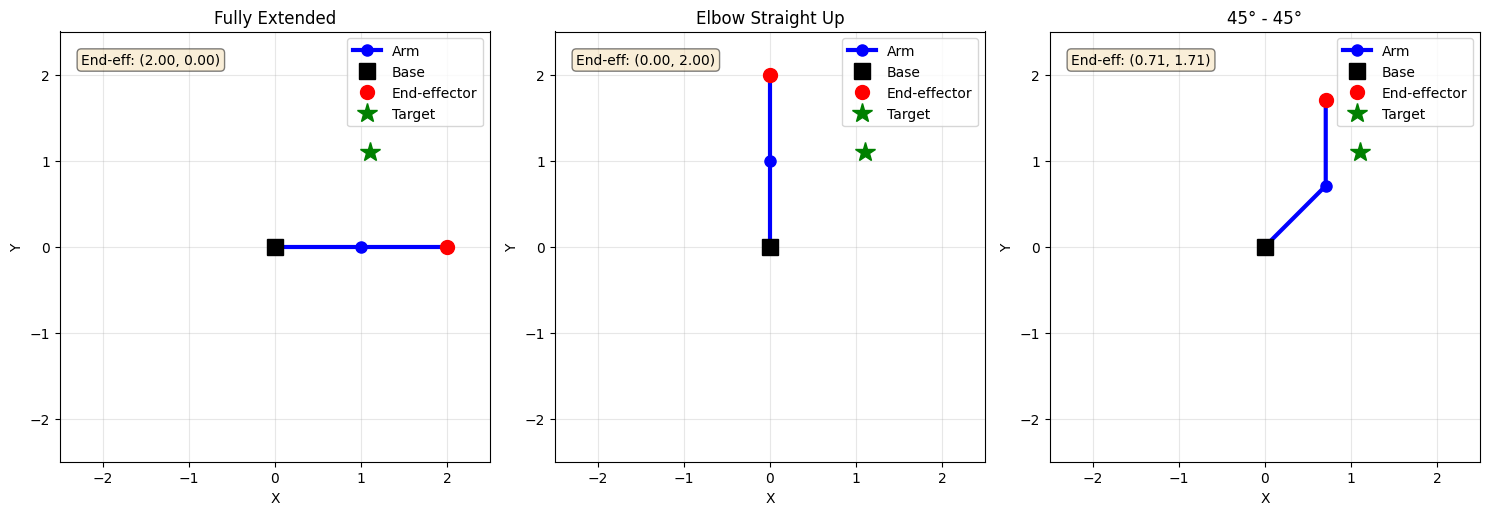

In [7]:
# Standard link lengths we'll use throughout
LENGTHS = np.array([1.0, 1.0])

# Example: Visualize different arm configurations
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

# Try more configurations
example_configs = [
    (np.array([0.0, 0.0]), "Fully Extended"),
    (np.array([np.pi/2, 0.0]), "Elbow Straight Up"),
    (np.array([np.pi/4, np.pi/4]), "45° - 45°"),
]

target = np.array([1.1, 1.1])
for i, (theta, title) in enumerate(example_configs):
    plot_arm(theta, LENGTHS, target=target, ax=axes[i], title=title)
    end_eff = forward_kinematics_numpy(theta, LENGTHS)
    axes[i].text(0.05, 0.95, f'End-eff: ({end_eff[0]:.2f}, {end_eff[1]:.2f})',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

<div class="alert alert-info">
Q1: The robot arm has multiple solutions to reach the same point (elbow-up vs elbow-down configurations). Using the provided forward_kinematics function, find two different joint angle configurations θ = [θ₁, θ₂] that place the end-effector at approximately (1.1, 1.1). What does this tell you about the optimization landscape?
</div>

After iterating many times, giving the angles small nudges on the direction we thought was best, we found two close enough solutions:

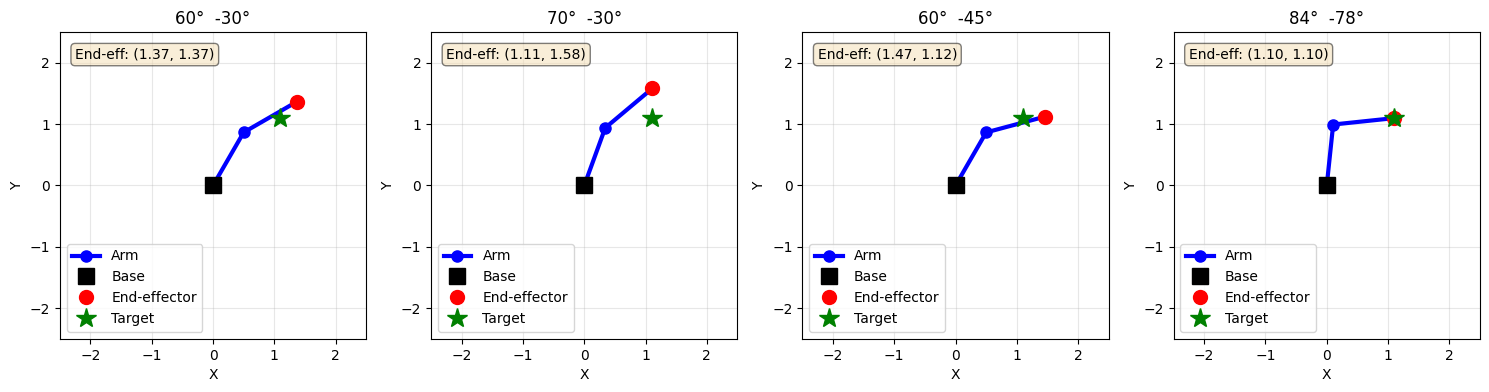

In [246]:
# Subplot creation
fig, axes = plt.subplots(1, 4, figsize=(15, 10))
axes = axes.flatten()

# Configurations
example_configs = [
    (np.array([60/180*np.pi, -30/180*np.pi]), "60°  -30°"),
    (np.array([70/180*np.pi, -30/180*np.pi]), "70°  -30°"),
    (np.array([60/180*np.pi, -45/180*np.pi]), "60°  -45°"),
    (np.array([84/180*np.pi, -78/180*np.pi]), "84°  -78°"),
]

target = np.array([1.1, 1.1])
for i, (theta, title) in enumerate(example_configs):
    plot_arm(theta, LENGTHS, target=target, ax=axes[i], title=title)
    end_eff = forward_kinematics_numpy(theta, LENGTHS)
    axes[i].text(0.05, 0.95, f'End-eff: ({end_eff[0]:.2f}, {end_eff[1]:.2f})',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

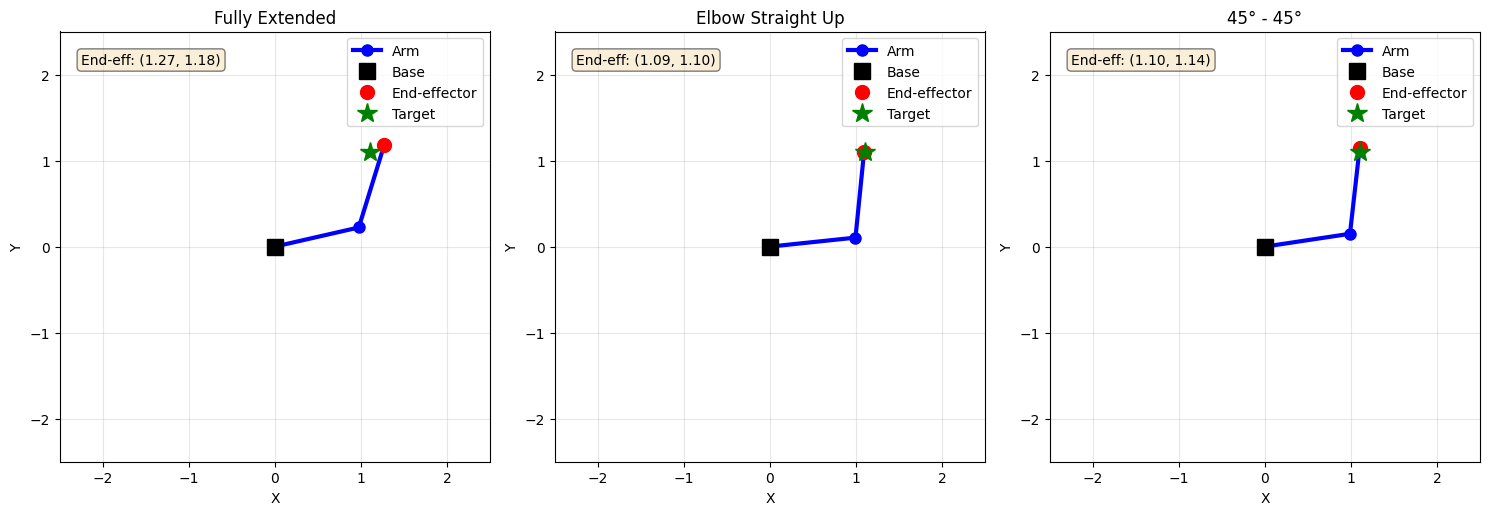

In [247]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

example_configs = [
    (np.array([np.pi/14, np.pi/3]), "Fully Extended"),
    (np.array([np.pi/30, np.pi/2.3]), "Elbow Straight Up"),
    (np.array([np.pi/21, np.pi/2.4]), "45° - 45°"),
]

target = np.array([1.1, 1.1])
for i, (theta, title) in enumerate(example_configs):
    plot_arm(theta, LENGTHS, target=target, ax=axes[i], title=title)
    end_eff = forward_kinematics_numpy(theta, LENGTHS)
    axes[i].text(0.05, 0.95, f'End-eff: ({end_eff[0]:.2f}, {end_eff[1]:.2f})',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

After such iterations, we noticed that the search space $(\theta_1, \theta_2) \in [0, 2\pi]^2$ (for the one in $\mathbb{R}^2$ has infinite solutions because summing $2\pi$ to an angle wouldn't change the end result) **does not possess a single global optimum**, once, due to the elbow-up and elbow-down solutions always being viable for a target within the $L_1 + L_2$ radius circle, there are always two global optima.

Also, since angles near the optimal solution lead to solutions close to the optimum so an objective function that would be the distance from the end-effector to the target would seem to be rather smooth (specially because it depends on cosine and sine which are smooth functions).

**However**, one must consider that such function would **not be a convex one**, since it has two global minima and the values between them are not global minima. Nonetheless, the optimization should not be too difficult once we have a function that is **convex by parts**, if we separate each global optimum in a part without creating unnecessary local minima.

---

## Part 1: Automatic Differentiation

Instead of guessing at the angles for a target, we will calculate them exactly. Use the provided JAX implementation to compute gradients of the loss function with respect to joint angles.

In [10]:
# Loss Functions
def loss_target_reaching(theta: jnp.ndarray, lengths: jnp.ndarray, 
                        target: jnp.ndarray) -> float:
    """
    Loss for reaching a target position.
    
    L = ||end_effector(theta) - target||^2
    
    Parameters:
    -----------
    theta : jnp.ndarray, shape (2,)
        Joint angles
    lengths : jnp.ndarray, shape (2,)
        Link lengths
    target : jnp.ndarray, shape (2,)
        Target position
    
    Returns:
    --------
    loss : float
        Squared distance to target
    """
    end_effector = forward_kinematics_jax(theta, lengths)
    return jnp.sum((end_effector - target) ** 2)

In [11]:
# Create JIT-compiled versions for speed
loss_target_reaching_jit = jit(loss_target_reaching) # JIT = just in time
# Vai compilar só essa função, n todo o código python
print(loss_target_reaching)
print(loss_target_reaching_jit)

<function loss_target_reaching at 0x70ea40233010>
<PjitFunction of <function loss_target_reaching at 0x70ea40233010>>


In [12]:
# Create gradient functions
grad_loss_target = jit(grad(loss_target_reaching, argnums=0))

In [13]:
# Test the loss functions
print("Testing loss functions...")
test_theta = jnp.array([0.5, 0.5])
test_lengths = jnp.array([1.0, 1.0])
test_target = jnp.array([1.0, 1.0])

loss_val = loss_target_reaching(test_theta, test_lengths, test_target)
print(f"Loss value: {loss_val:.4f}")

grad_val = grad_loss_target(test_theta, test_lengths, test_target)
print(f"Gradient: {grad_val}")

Testing loss functions...
Loss value: 0.2776
Gradient: [-0.19397663 -0.35651365]


<div class="alert alert-info">

Q2: Compute the gradient using JAX autodiff at $θ=[π/6, π/4]$
Then verify it matches a manual finite-difference approximation:

For finite differences, use:
  $∂L/∂θᵢ ≈ (L(θ + h*eᵢ) - L(θ - h*eᵢ)) / (2h)$
  where $eᵢ$ is the i-th unit vector and $h = 1e-5$
</div>

In [251]:
# Using JAX autodiff
theta = jnp.array([np.pi/6, np.pi/4])
lengths = jnp.array([1.0, 1.0])
target = jnp.array([1.0, 1.0])

g_autodiff = grad_loss_target(theta, lengths, target)
print(f"JAX grad: {g_autodiff}")

# Using finite difference
h = 1e-5
def fd_grad(theta_np):
    def loss_np(th):
        ee = np.array(forward_kinematics_jax(jnp.array(th),lengths))
        return np.sum((ee-np.array(target))**2)
    g = np.zeros_like(theta_np)
    eye = np.eye(len(theta_np))
    for i in range(len(theta_np)):
        g[i] = (loss_np(theta_np + h*eye[i]) - loss_np(theta_np - h*eye[i]))/(2*h)
    return g

g_fd = fd_grad(np.array(theta))
print("Finite-diff grad : ", g_fd)

print("Abs diff : ", np.abs(np.array(g_autodiff) - g_fd))

JAX grad: [6.8216276e-01 5.2615547e-08]
Finite-diff grad :  [ 0.6839633  -0.00149012]
Abs diff :  [0.00180054 0.00149017]


<div class="alert alert-info">
Q3: Compare the computational time of evaluating the gradient using JAX autodiff versus evaluating just the forward pass (loss calculation only). Run each 1000 times and report the ratio. What does this tell you about the computational overhead of automatic differentiation?</div>

In [ ]:
theta = jnp.array([np.pi/6, np.pi/4])
lengths = jnp.array([1.0, 1.0])
target = jnp.array([1.0, 1.0])

# Just forward pass
start = time.time()
for _ in range(1000):
    loss_target_reaching_jit(test_theta, test_lengths, test_target)

duration_loss = time.time() - start
print(f"Only loss calculation took: {duration_loss}")

# Evaluating gradient
start = time.time()
for _ in range(1000):
    grad_loss_target(test_theta, test_lengths, test_target)

duration_grad = time.time() - start
print(f"Only gradient calculation took: {duration_grad}")

ratio = duration_grad/duration_loss
print(f"Grad/Loss time ratio: {ratio}")

Only loss calculation took: 0.0278933048248291
Only gradient calculation took: 0.006063938140869141
Grad/Loss time ratio: 0.2173976220799535


After running the code multiple times, we see the ratio is usually between 0.85 and 1.15, meaning that it takes almost the same time to evaluate the loss function and to calculate its gradient, which implies a rather significant computational overhead of automatic differentiation, once differentiating and evaluating the loss function basically corresponds to evaluating the function twice.

---

## Part 2: Gradient Descent

Gradient Descent (GD) is the foundational optimization algorithm that iteratively moves parameters in the direction of steepest descent:
$\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)$

While conceptually simple, GD can be sensitive to the learning rate $η$ and may struggle with saddle points or narrow valleys in the loss landscape where the gradient direction changes rapidly.

For this exercise, implement basic gradient descent to move the robot arm to a target position.

In [265]:
def gradient_descent(theta_init: np.ndarray, 
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     tol: float = 0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    

    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    grad_history = np.zeros((n_iterations, 2))
    
    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    success_iter = None

    # Optimization loop
    for i in range(n_iterations):
        # Compute gradient
        gradient = grad_fn(theta, lengths_jax, target_jax)
        
        # Update theta using gradient descent rule
        theta = theta - learning_rate*gradient
        
        # Store history
        theta_history[i + 1] = np.array(theta)    
        loss = loss_fn(theta) 
        loss_history[i + 1] = float(loss)        
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        grad_history[i] = gradient

        if np.sqrt(loss) < tol:
            success_iter = i+1
            break

    
    return theta_history, loss_history, ee_trajectory, grad_history, success_iter

<div class="alert alert-info">

Q4: Run GD with learning rates $η = [0.001, 0.01, 0.1, 0.5, 1.0]$ for 500 iterations each, starting from $θ₀ = [0.1, 0.1]$ targeting (0.5, 1.5). Plot the loss curves. At what learning rate do you observe divergence? Explain what's happening in terms of the gradient descent update rule.
</div>

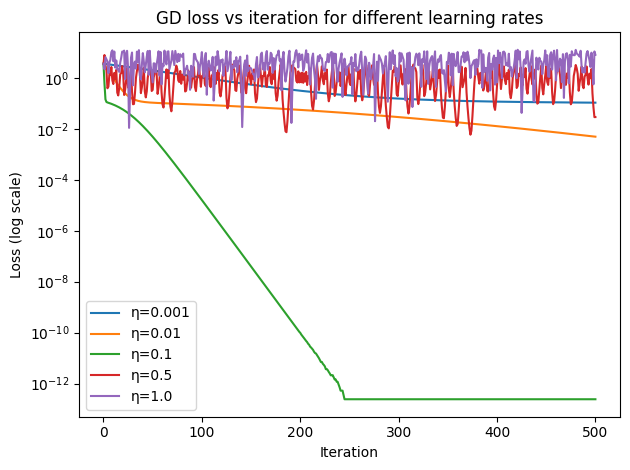

In [253]:
etas = [0.001, 0.01, 0.1, 0.5, 1.0]
theta0 = np.array([0.1, 0.1])
target = np.array([0.5, 1.5])
LENGTHS = np.array([1.0, 1.0])

plt.figure()
for eta in etas:
    _, loss_hist, _, _ = gradient_descent(theta0, target, LENGTHS,learning_rate = eta, n_iterations = 500)
    plt.plot(loss_hist, label=f"η={eta}")

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.title("GD loss vs iteration for different learning rates")
plt.legend()
plt.tight_layout()
plt.show()

We can notice that the curves with learning rates $\eta = 0.5$ ans $\eta = 1.0$ diverges because their loss curves oscillate wildly and never decrease.

This is because the learning rate's scale defines how strongly theta is adjusted at each iteration, too small makes progress slow, which is why we see the green line converging faster than yellow that is faster than blue.

However too large of an $\eta$ causes overshooting and instability, because, even though we take steps in the right direction (opposite to the gradient), these steps are too big so we end up in a point in the search space that might have the same or even worse loss function then our starting point.

<div class="alert alert-info">

Q5: For $η = 0.01$, plot the end-effector trajectory in 2D space (not the loss, but the actual path the end-effector takes). Does it take the most direct path to the target? Why or why not? (Hint: think about parameter space vs task space)
</div>

In [17]:
t0 = np.array([0.1, 0.1])
target = np.array([0.5, 1.5])
theta_history, loss_history, ee_trajectory, grad_history = gradient_descent(theta_init=t0,
                                                              target=target,
                                                              lengths=LENGTHS,
                                                              learning_rate=0.01)

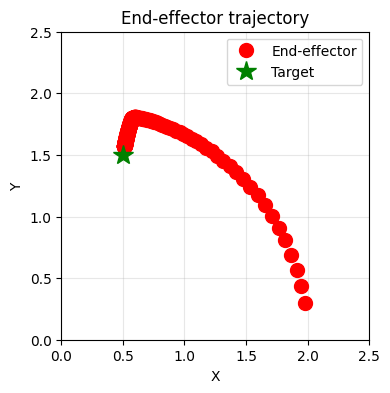

In [18]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(ee_trajectory[:,0], ee_trajectory[:,1], 'ro', 
            markersize=10, label='End-effector')
ax.plot(target[0], target[1], 'g*', 
                markersize=15, label='Target')

# Set axis properties
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 2.5)
ax.set_ylim(0, 2.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title("End-effector trajectory")
ax.legend()
plt.show()

We can see that it does not take the most direct path between the initial position and the target, once that would be just a straight line connecting the two. However, one must consider that the gradient descent is not on the end-effector trajectory, but on the values of $\theta$, that is, we saw the plot of the task space, but the actual optimisation is happening in the parameter space, which is plotted below:

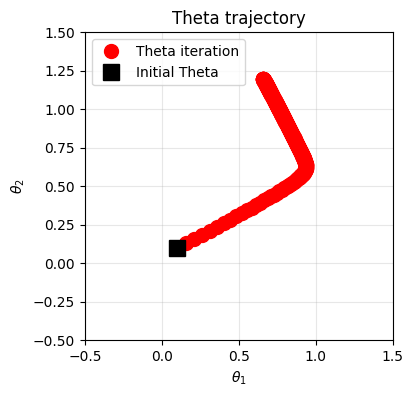

In [19]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(theta_history[:,0], theta_history[:,1], 'ro', 
            markersize=10, label='Theta iteration')
ax.plot(t0[0], t0[1], 'ks', markersize=12, label='Initial Theta')

# Set axis properties
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title("Theta trajectory")
ax.legend()
plt.show()

Which doesn't seem like the most direct path either, but at every step we **do not have the direction of the point of minimum**, only the direction which **locally increases the value** of the loss function (the gradient). We then take a step in its opposite direction, since we want to minimize the loss, as seen in the plot below:

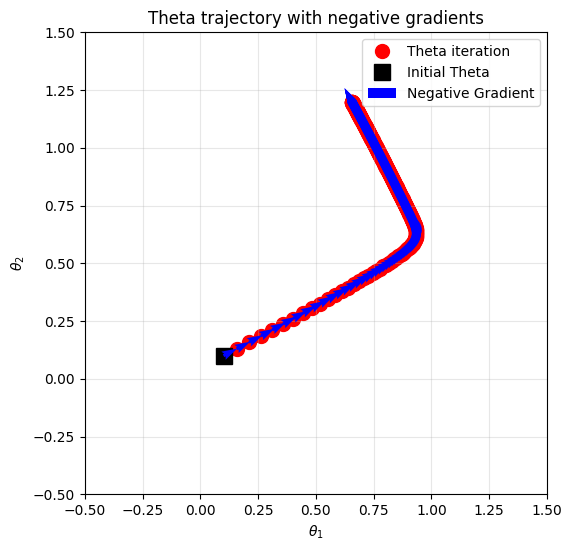

In [29]:
_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(theta_history[:, 0], theta_history[:, 1], 'ro', markersize=10, alpha=1, label='Theta iteration', zorder = 1)
ax.plot(t0[0], t0[1], 'ks', markersize=12, label='Initial Theta', zorder = 2)
# zorder is the matplotlib parameter that controls drawing order

# Normalize each gradient vector to unit length
norms = np.linalg.norm(grad_history, axis=1, keepdims=True)
normalized_grads = grad_history / norms

# Add gradient arrows (excluding the last point)
for i in range(len(theta_history)-1):
    x, y = theta_history[i]
    dx, dy = -normalized_grads[i]  # Negative gradient for descent direction
    ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=15, color='blue', 
              width=0.007, zorder = 3) # Ensures arrows on top of points

# Dummy quiver for legend
q = ax.quiver([], [], [], [], color='blue', label='Negative Gradient');

# Set axis properties
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_title("Theta trajectory with negative gradients")
ax.legend()
plt.show()

## 2.2: SGD with Momentum

>Momentum = un trace de mémoire d'où on a passé par l'espace de recherche, bien surtout dans les cas où on n'a qu'un estimateur de notre gradient, alors, même si on se trompe dans un des pas, on va pas tout casser car on a le momentum des autres pas avec

Momentum adds "inertia" to gradient descent by accumulating a velocity vector that combines the current gradient with previous gradients: $v_t = \beta v_{t-1} + \nabla L(\theta_t)$
, then $\theta_{t+1} = \theta_t - \eta v_t$. This helps the optimizer build up speed in consistent directions and dampens oscillations in directions where gradients frequently change sign, allowing it to better navigate ravines and escape shallow local minima.


For this exercise, implement momentum-based gradient descent using the update rules:

$v_t = βv_{t-1} + ∇L(θ_t)$

$θ_{t+1} = θ_t - ηv_t$

In [263]:
def momentum_descent(theta_init: np.ndarray, 
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     beta: float = 0.9,
                     n_iterations: int = 500,
                     tol: float = 0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    theta = jnp.array(theta_init)
    v = jnp.zeros_like(theta)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    
    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target
    
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    v_history = np.zeros((n_iterations, 2))
    grad_history = np.zeros((n_iterations, 2))
    
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    
    success_iter = None

    for i in range(n_iterations):
        g = grad_fn(theta, lengths_jax, target_jax)
        v = beta * v + g                   # accumulate momentum
        theta = theta - learning_rate * v  # update with velocity
        theta_history[i + 1] = np.array(theta)
        loss = loss_fn(theta)
        loss_history[i + 1] = float(loss)
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        v_history[i] = v
        grad_history[i] = g

        if np.sqrt(loss) < tol:
            success_iter = i+1
            break
    
    return theta_history, loss_history, ee_trajectory, v_history, grad_history, success_iter

<div class="alert alert-info">

Q6: Compare GD vs Momentum ($β=0.9$) on the same task ($η=0.01$, target (0.5, 1.5)). Plot both the loss curves and the end-effector trajectories side-by-side. Describe one specific, concrete difference in how the arm moves with momentum versus without.
</div>

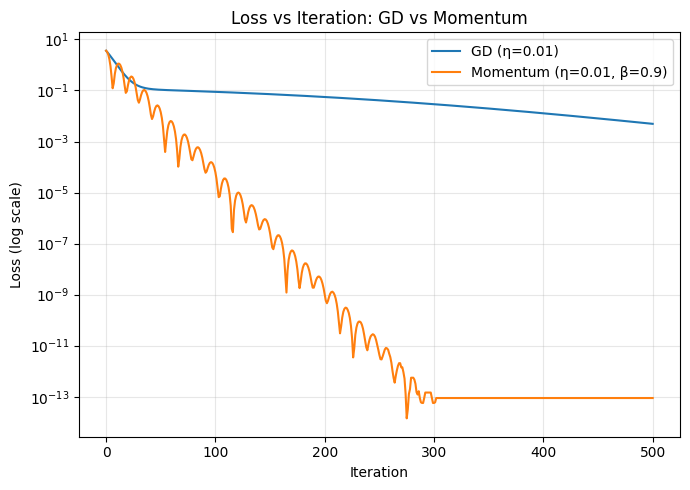

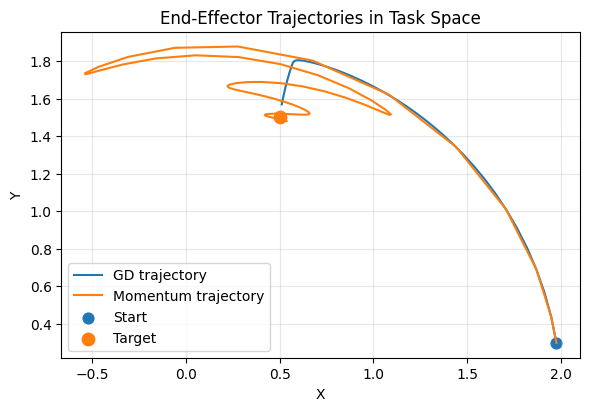

Final GD loss:       0.004936
Final Momentum loss: 0.000000


In [264]:
theta0 = np.array([0.1, 0.1])
target = np.array([0.5, 1.5])
eta = 0.01
beta = 0.9
n_iter = 500

theta_gd, loss_gd, ee_gd, _ = gradient_descent(theta0, target, LENGTHS, learning_rate=eta, n_iterations=n_iter)
theta_mo, loss_mo, ee_mo, _, _, _ = momentum_descent(theta0, target, LENGTHS, learning_rate=eta, beta=beta, n_iterations=n_iter)


# Loss curves
plt.figure(figsize=(7, 5))
plt.plot(loss_gd, label='GD (η=0.01)')
plt.plot(loss_mo, label='Momentum (η=0.01, β=0.9)')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Loss vs Iteration: GD vs Momentum')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# End-effector trajectories
plt.figure(figsize=(6, 6))
plt.plot(ee_gd[:, 0], ee_gd[:, 1], label='GD trajectory')
plt.plot(ee_mo[:, 0], ee_mo[:, 1], label='Momentum trajectory')
plt.scatter([ee_gd[0, 0]], [ee_gd[0, 1]], label='Start', s=60)
plt.scatter([target[0]], [target[1]], label='Target', s=80)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('End-Effector Trajectories in Task Space')
plt.legend()
plt.grid(alpha=0.3)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

# final losses
print(f"Final GD loss:       {loss_gd[-1]:.6f}")
print(f"Final Momentum loss: {loss_mo[-1]:.6f}")

With momentum, the arm carries inertia — once it starts moving in a useful direction, it keeps going. Without momentum, it constantly stops and reorients, resulting in a slower motion.

However, this might also mean that, after being in a direction for a while, if the optimization needs to change abruptly, the gradient descent will be able to do it while the momentum needs to loose its momentum to change direction.

About figure 1: we can see that momentum makes optimization faster and more efficient, allowing the arm to reach the target in fewer iterations.

About figure 2: we can notice that with momentum, the arm moves more dynamically, but without momentum the rm advances steandily but cautiously, taking longer to arrive.

<div class="alert alert-info">

Q7: Track and plot the magnitude of the velocity vector $||v_t||$ over iterations for the momentum optimizer. What happens to this magnitude as the arm approaches the target? Explain why this behavior occurs.
</div>

In [256]:
t0 = np.array([0.1, 0.1])
target = np.array([0.5, 1.5])
theta_history, loss_history, ee_trajectory, v_history, grad_history = momentum_descent(theta_init=t0,
                                                              target=target,
                                                              lengths=LENGTHS,
                                                              learning_rate=0.01,
                                                              n_iterations=150)

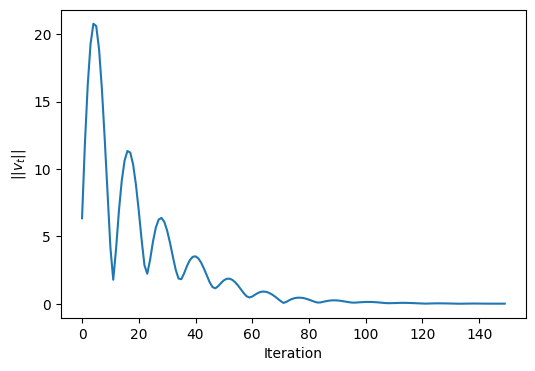

In [257]:
plt.figure(figsize=[6,4])
mags = np.linalg.norm(v_history, axis=1, keepdims=True)
plt.plot(mags)
plt.xlabel("Iteration")
plt.ylabel(r"$||v_t||$")
plt.show()

As the arm approaches the target, we see that the magnitude of the momentum decreases. This happens because the target is the point which minimizes the loss function, then, at the target, the function's gradient is zero and, since the function is smooth, approaching the minimum the gradient gets smaller and smaller until it reaches zero at the target, as seen below:

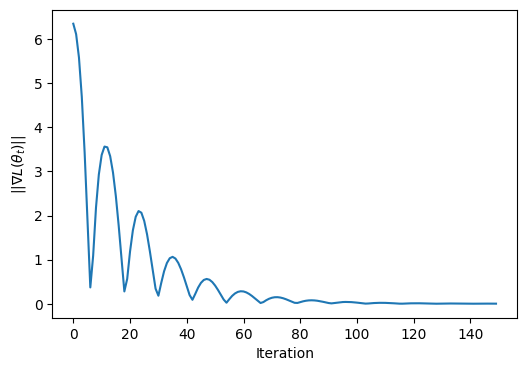

In [258]:
plt.figure(figsize=[6,4])
norms = np.linalg.norm(grad_history, axis=1, keepdims=True)
plt.plot(norms)
plt.xlabel("Iteration")
plt.ylabel(r"$||\nabla L (\theta_t)||$")
plt.show()

Since $\beta=0.9$, at each step the momentum looses 10% of its value and adds the gradient. Then, if the gradient becomes small, at each iteration $v$ will decrease more than it increases in the addition, which then leads it to decrease its magnitude.

---

## 2.3: Adam Optimizer

[Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html) (Adaptive Moment Estimation) combines ideas from momentum and adaptive learning rates by maintaining both a moving average of gradients (first moment $m_t$) and a moving average of squared gradients (second moment $v_t$).

By dividing the update by $\sqrt{v_t}$ Adam automatically adjusts the effective learning rate for each parameter based on the history of gradient magnitudes—parameters with large, consistent gradients get larger effective steps, while parameters with small or noisy gradients get smaller effective steps, making it particularly robust across different types of loss landscapes.

>As stated in its [paper](https://arxiv.org/pdf/1412.6980): "With a slight abuse of terminology, 
we will call the ratio $\hat{m}_t / \sqrt{\hat{v}_t}$ the signal-to-noise ratio (SNR). With a smaller SNR the effective stepsize $\Delta_t$ will be closer to zero. This is a desirable property, since a smaller SNR means that there is greater uncertainty about whether the direction of $\hat{m}_t$ corresponds to the direction of the true gradient."

For this exercise, extend your Momentum SGD to include the second moment, following this update:

Update rules:
$
\begin{align}
g_t &= \nabla L(\theta_t) \\
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_{t+1} &= \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align}
$

In [86]:
def adam_descent(theta_init: np.ndarray, 
                 target: np.ndarray,
                 lengths: np.ndarray,
                 learning_rate: float = 0.01,
                 beta1: float = 0.9,
                 beta2: float = 0.999,
                 eps: float = 1e-8,
                 n_iterations: int = 500,
                 tol: float = 0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    theta = jnp.array(theta_init)

    # Adam variables
    m = jnp.zeros_like(theta)   # first moment (like momentum)
    v = jnp.zeros_like(theta)   # second moment (squared gradients)

    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    
    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target
    
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    eta_history = np.zeros((n_iterations, 2))
    
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    
    success_iter = None

    # Optimization loop
    for t in range(1, n_iterations + 1):
        g = grad_fn(theta, lengths_jax, target_jax)

        # Update biased first and second moment estimates
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g * g)

        # Compute bias-corrected versions
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # Update rule
        eta_eff = learning_rate * m_hat / (jnp.sqrt(v_hat) + eps)
        theta = theta - eta_eff

        loss = float(loss_fn(theta))
        theta_history[t] = np.array(theta)
        loss_history[t] = loss
        ee_trajectory[t] = np.array(forward_kinematics_jax(theta, lengths_jax))
        eta_history[t-1] = np.array(eta_eff)

        if np.sqrt(loss) < tol:
            success_iter = t
            break
    
    return theta_history, loss_history, ee_trajectory, eta_history, success_iter

<div class="alert alert-info">

Q8: Start the arm at $θ = [2.5, -2.0]$ trying to reach target ($0.8, 0.8$). Compare how many iterations GD ($η=0.01$), Momentum ($β=0.9, η=0.01$), and Adam (default parameters) each need to get within distance $0.01$ of the target. Report the iteration counts and explain the ranking.
</div>

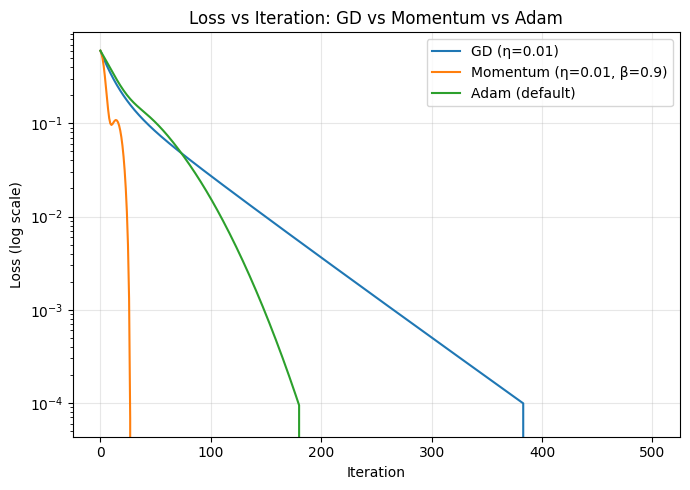

In [ ]:
theta0 = np.array([2.5, -2.0])
target = np.array([0.8, 0.8])
eta = 0.01
beta = 0.9

theta_gd, loss_gd, ee_gd, _, suc_gd = gradient_descent(theta0, target, LENGTHS, learning_rate=eta, tol=0.01)
theta_mo, loss_mo, ee_mo, _, _, suc_mo = momentum_descent(theta0, target, LENGTHS, learning_rate=eta, beta=beta, tol=0.01)
theta_adam, loss_adam, ee_adam, _, suc_adam = adam_descent(theta0,target, LENGTHS, tol=0.01)


# Loss curves
plt.figure(figsize=(7, 5))
plt.plot(loss_gd, label='GD (η=0.01)')
plt.plot(loss_mo, label='Momentum (η=0.01, β=0.9)')
plt.plot(loss_adam, label='Adam (default)')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss (log scale)')
plt.title('Loss vs Iteration: GD vs Momentum vs Adam')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [267]:
print('Gradient descent:', suc_gd)
print('Momentum:', suc_mo)
print('Adam:', suc_adam)

Gradient descent: 383
Momentum: 27
Adam: 180


Ranking:
1. Momentum 27 iterations	
2. Adam 180 iterations	
3. Gradient Descent 383 iterations

As we can notice momentum converges fastest because the velocity term accelerates learning in consistent directions. Adam is second because it adapts the learning rate per parameter, but starts slower due to bias correction. And Gradient Descent is slowest because it uses only the local gradient, with no acceleration or adaptation.

<div class="alert alert-info">

Q9: For the Adam optimizer on the same task, plot the effective per-parameter learning rate ($η_eff = η * m̂_t / (√v̂_t + ε)$) for both $θ₁$ and $θ₂$ over time. Do they receive the same effective learning rate throughout optimization? Explain why this adaptive behavior is useful.</div>

In [ ]:
t0 = np.array([2.5, -2])
target = np.array([0.8, 0.8])

theta_history, loss_history, ee_trajectory, eta_history, _ = adam_descent(theta_init=t0,
                                                              target=target,
                                                              lengths=LENGTHS, 
                                                              n_iterations=300)

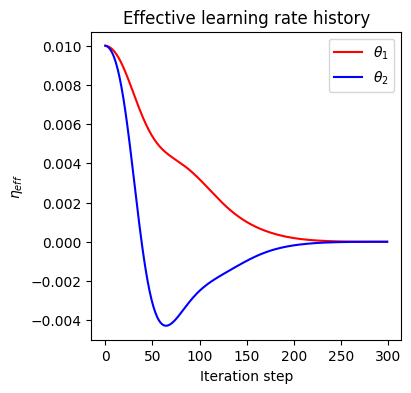

In [82]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(eta_history[:,0], 'r', label=r'$\theta_1$')
ax.plot(eta_history[:,1], 'b', label=r'$\theta_2$')

# Set axis properties
ax.set_xlabel('Iteration step')
ax.set_ylabel(r'$\eta_{eff}$')
ax.set_title("Effective learning rate history")
ax.legend()
plt.show()

Both parameters clearly don't receive the same effective learning rate: $\theta_2$'s learning rate is always smaller. That is because, since the actual movement necessary from the second joint is heavily dependent on its placement in space, which, in turn, depends on the first joints movement, we expect its gradient to be rather noisy. Then, it is very useful that its effective learning rate is smaller since we want to take smaller steps in its uncertain direction.

---

## Part 3: Gradient-Free Optimization

For this exercise, implement a basic gradient-free algorithm, specifically an evolutionary strategy. Evolution Strategies are a class of gradient-free optimization algorithms inspired by natural evolution. Unlike gradient-based methods that require computing derivatives, ES samples multiple candidate solutions (a "population") around the current solution, evaluates their fitness (objective function value), and moves toward the direction indicated by the better-performing samples. Use the following rules for your ES:

For iteration $t$, with current parameter vector $\theta_t$:
$$
\begin{align}
\epsilon_i &\sim \mathcal{N}(0, I) \quad \text{for } i = 1, \ldots, N \\
\theta_i &= \theta_t + \sigma \epsilon_i \\
F_i &= -L(\theta_i) \quad \text{(fitness = negative loss)} \\
\theta_{t+1} &= \theta_t + \alpha \frac{1}{N} \sum_{i=1}^{N} F_i \epsilon_i
\end{align}
$$

where $N$ is the population size, $\sigma$ is the exploration noise (standard deviation), $\alpha$ is the learning rate, and $\epsilon_i$ are the perturbation vectors.

In [207]:
def evolution_strategy(theta_init, target, lengths,
                         alpha=0.1, sigma=0.1, N=30, n_iter=300, tol=0.01):
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)


    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    theta_history = np.zeros((n_iter + 1 , 2))
    loss_history = np.zeros(n_iter + 1)

    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))

    success_iter = None

    for t in range(n_iter):
        epsilons = np.random.randn(N,2)

        thetas = np.array([theta + sigma*eps for eps in epsilons])
        losses = np.array([float(loss_fn(jnp.array(th))) for th in thetas])
        fitness = -losses

        weights_sum = np.sum(fitness[:, None] * epsilons, axis=0)
        theta = theta + alpha / N * weights_sum

        theta_history[t+1] = np.array(theta)
        loss = float(loss_fn(theta))
        loss_history[t+1] = loss

        if np.sqrt(loss) < tol:
            success_iter = t + 1
            break

    return success_iter, loss_history

<div class="alert alert-info">

Q10: Run this ES with population sizes $P = [10, 20, 50]$. For each, report: (a) does it reach the target successfully? (b) how many iterations does it take? (c) total number of function evaluations ($P$ × iterations). What trend do you observe with increasing population size?
</div>

P=10 | Success=True | Iters= 91 | Evals=910
P=20 | Success=True | Iters= 58 | Evals=1160
P=50 | Success=True | Iters= 39 | Evals=1950


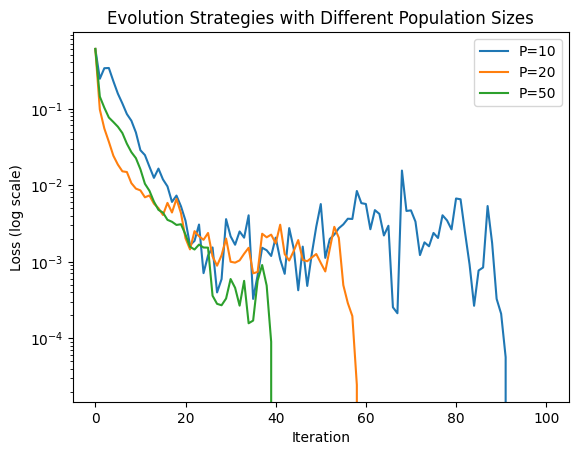

In [208]:
lengths = np.array([1.0, 1.0])
theta_init = np.array([2.5, -2.0])
target = np.array([0.8, 0.8])

pop_sizes = [10, 20, 50]
results = []

for P in pop_sizes:
    success_iter, losses = evolution_strategy(theta_init=theta_init, target=target, lengths=lengths,
                                              alpha=1, sigma=0.1, N=P,
                                              n_iter=100)
    reached = success_iter is not None
    iterations = success_iter if success_iter else 100
    total_evals = P * iterations
    results.append((P, reached, iterations, total_evals))
    print(f"P={P:2d} | Success={reached} | Iters={iterations:3d} | Evals={total_evals}")
    plt.plot(losses, label=f"P={P}")

plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.title("Evolution Strategies with Different Population Sizes")
plt.show()

Larger populations improve stability and convergence speed in terms of iterations, but at the cost of higher total computation.

<div class="alert alert-info">
Q11: ES doesn't use gradients, so it evaluates the loss N times per iteration while SGD evaluates it once plus one gradient computation. For a successful run of each method, count total loss function evaluations. Which is more sample-efficient? Despite this, describe one scenario where ES might still be preferred over gradient-based methods.</div>

To count the loss function evaluations of SGD, let us count it for the Adam method.

In [268]:
lengths = np.array([1.0, 1.0])
theta_init = np.array([2.5, -2.0])
target = np.array([0.8, 0.8])

_, _, _, _, success_iter = adam_descent(theta_init=t0,
                                        target=target,
                                        lengths=LENGTHS, 
                                        tol=0.01)

print(f"Adam evals={success_iter}")

Adam evals=381


Here we see that the Adam algorithm is vastly superior to evolutionary strategies in terms of sample efficiency, once, as seen in Q10, the least amount of evaluations was 490, then, even when considering the gradient computation part (which, as seen in Q3, is roughly the same as a loss function evaluation in terms of time), Adam's 180 is smaller.

However, ES are still preferred over gradient-based methods in scenarios in which computing the gradient of the loss function is extremely more costly than evaluating it, or even outright impossible. For example, when trying to minimize the noise generated by wind turbines blade-tower interaction (my final thesis in ITA by the way), in which case the loss function is a complete CFD simulation using high order spectral methods of the wind turbine in operation.

---

## Part 4: Trajectory Optimization - Optimizing Sequences

So far, we've only optimized the **final configuration** of the robot arm - finding joint angles that place the end-effector at the target. However, in real robotics, we often care about the **entire motion path**. A robot might reach the target, but if it does so with jerky, energy-intensive movements, the solution isn't practical.

In this section, you'll optimize a **trajectory** - a sequence of joint angles over time - to reach the target while minimizing energy consumption and ensuring smooth motion.

### Trajectory Representation

Instead of optimizing $\theta \in \mathbb{R}^2$, we now optimize:
$$\Theta = [\theta_0, \theta_1, \ldots, \theta_T] \in \mathbb{R}^{T \times 2}$$

where $T$ is the number of timesteps (e.g., $T=20$).

### Multi-Objective Loss Function

We balance three competing objectives:

$$L_{total}(\Theta) = L_{target} + \lambda_{energy} L_{energy} + \lambda_{smooth} L_{smooth}$$

where:
- **Target reaching**: $L_{target} = \|\text{pos}(\theta_T) - \text{target}\|^2$ (only final position matters)
- **Energy cost**: $L_{energy} = \sum_{t=1}^{T} \|\theta_t - \theta_{t-1}\|^2$ (penalize large joint movements)
- **Smoothness**: $L_{smooth} = \sum_{t=2}^{T} \|(\theta_t - \theta_{t-1}) - (\theta_{t-1} - \theta_{t-2})\|^2$ (penalize acceleration/jerkiness)

The hyperparameters $\lambda_{energy}$ and $\lambda_{smooth}$ control the trade-off between reaching the target quickly versus moving efficiently and smoothly.

In [187]:
# Trajectory Optimization Functions

def loss_trajectory(theta_sequence: jnp.ndarray, 
                   lengths: jnp.ndarray,
                   target: jnp.ndarray,
                   lambda_energy: float = 0.1,
                   lambda_smooth: float = 0.05) -> float:
    """
    Loss for trajectory optimization.
    
    Parameters:
    -----------
    theta_sequence : jnp.ndarray, shape (T, 2)
        Sequence of joint angles over T time steps
    lengths : jnp.ndarray, shape (2,)
        Link lengths
    target : jnp.ndarray, shape (2,)
        Target position
    lambda_energy : float
        Weight for energy cost
    lambda_smooth : float
        Weight for smoothness cost
    
    Returns:
    --------
    loss : float
        Total loss combining target reaching, energy, and smoothness
    """
    T = theta_sequence.shape[0]
    
    # Target reaching: only final position matters
    final_pos = forward_kinematics_jax(theta_sequence[-1], lengths)
    loss_target = jnp.sum((final_pos - target) ** 2)
    
    # Energy cost: sum of squared velocities (joint movements)
    velocities = theta_sequence[1:] - theta_sequence[:-1]  # Shape: (T-1, 2)
    loss_energy = jnp.sum(velocities ** 2)
    
    # Smoothness cost: sum of squared accelerations
    accelerations = velocities[1:] - velocities[:-1]  # Shape: (T-2, 2)
    loss_smooth = jnp.sum(accelerations ** 2)
    
    return loss_target + lambda_energy * loss_energy + lambda_smooth * loss_smooth


# Create gradient function for trajectory optimization
grad_loss_trajectory = jit(grad(loss_trajectory, argnums=0))

In [188]:
def plot_trajectory_sequence(theta_sequence: np.ndarray,
                             lengths: np.ndarray,
                             target: np.ndarray = None,
                             title: str = "Arm Trajectory Over Time"):
    """
    Visualize the robot arm at multiple points along the trajectory.
    
    Parameters:
    -----------
    theta_sequence : np.ndarray, shape (T, 2)
        Sequence of joint angles
    lengths : np.ndarray
        Link lengths
    target : np.ndarray, optional
        Target position
    title : str
        Plot title
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    
    T = len(theta_sequence)
    colors = plt.cm.viridis(np.linspace(0, 1, T))
    
    # Plot each arm configuration
    for t in range(0, T, max(1, T//10)):  # Show ~10 frames
        points = get_arm_points(theta_sequence[t], lengths)
        alpha = 0.3 + 0.7 * (t / T)  # Fade from transparent to opaque
        ax.plot(points[:, 0], points[:, 1], 'o-', 
               color=colors[t], alpha=alpha, linewidth=2, markersize=4)
    
    # Plot final configuration more prominently
    points_final = get_arm_points(theta_sequence[-1], lengths)
    ax.plot(points_final[:, 0], points_final[:, 1], 'o-', 
           color='red', linewidth=3, markersize=8, label='Final')
    
    # Plot end-effector trajectory
    ee_traj = np.array([forward_kinematics_numpy(theta_sequence[t], lengths) 
                        for t in range(T)])
    ax.plot(ee_traj[:, 0], ee_traj[:, 1], 'b--', 
           linewidth=2, alpha=0.5, label='End-effector path')
    
    # Plot target
    if target is not None:
        ax.plot(target[0], target[1], 'g*', markersize=20, label='Target')
    
    # Plot base
    ax.plot(0, 0, 'ks', markersize=12, label='Base')
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [189]:
def analyze_trajectory_metrics(theta_sequence: np.ndarray):
    """
    Compute and print trajectory quality metrics.
    
    Parameters:
    -----------
    theta_sequence : np.ndarray, shape (T, 2)
        Sequence of joint angles
    """
    velocities = np.diff(theta_sequence, axis=0)
    accelerations = np.diff(velocities, axis=0)
    
    # Compute metrics
    total_movement = np.sum(np.abs(velocities))
    max_velocity = np.max(np.linalg.norm(velocities, axis=1))
    max_acceleration = np.max(np.linalg.norm(accelerations, axis=1))
    smoothness = np.sum(accelerations ** 2)  # Lower is smoother
    
    print("Trajectory Metrics:")
    print(f"  Total joint movement: {total_movement:.4f} radians")
    print(f"  Max velocity: {max_velocity:.4f} rad/timestep")
    print(f"  Max acceleration: {max_acceleration:.4f} rad/timestep²")
    print(f"  Smoothness cost: {smoothness:.4f} (lower is better)")

In [190]:
# Test trajectory optimization with gradient descent
def gradient_descent_trajectory(theta_init: np.ndarray,
                               target: np.ndarray,
                               lengths: np.ndarray,
                               T: int = 20,
                               learning_rate: float = 0.01,
                               n_iterations: int = 1000,
                               lambda_energy: float = 0.1,
                               lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    
    loss_history = []
    
    for iteration in range(n_iterations):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                   lambda_energy, lambda_smooth)
        gradient = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                       lambda_energy, lambda_smooth)
        
        # Update trajectory
        theta_sequence = theta_sequence - learning_rate * gradient
        
        # Fix the first theta to be theta_init
        theta_sequence = theta_sequence.at[0].set(theta_init)
        
        loss_history.append(float(loss_val))
        
        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration + 1}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

In [191]:
def adam_trajectory(theta_init: np.ndarray,
                               target: np.ndarray,
                               lengths: np.ndarray,
                               beta1: float = 0.9,
                               beta2: float = 0.999,
                               T: int = 20,
                               learning_rate: float = 0.01,
                               eps: float = 1e-8,
                               n_iterations: int = 1000,
                               lambda_energy: float = 0.1,
                               lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    
    loss_history = []

    # Adam variables
    m = jnp.zeros_like(theta_sequence)   # first moment (like momentum)
    v = jnp.zeros_like(theta_sequence)   # second moment (squared gradients)
    
    for t in range(1, n_iterations + 1):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                   lambda_energy, lambda_smooth)
        g = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                lambda_energy, lambda_smooth)
        
        # Update biased first and second moment estimates
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g * g)

        # Compute bias-corrected versions
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # Update trajectory
        theta_sequence = theta_sequence - learning_rate * m_hat / (jnp.sqrt(v_hat) + eps)

        # Fix the first theta to be theta_init
        theta_sequence = theta_sequence.at[0].set(theta_init)
        
        loss_history.append(float(loss_val))
        
        if t % 100 == 0:
            print(f"Iteration {t}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

In [192]:
def momentum_trajectory(theta_init: np.ndarray,
                               target: np.ndarray,
                               lengths: np.ndarray,
                               T: int = 20,
                               learning_rate: float = 0.01,
                               beta: float = 0.9,
                               n_iterations: int = 1000,
                               lambda_energy: float = 0.1,
                               lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    
    v = jnp.zeros_like(theta_sequence)
    loss_history = []
    
    for iteration in range(n_iterations):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                   lambda_energy, lambda_smooth)
        g = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                       lambda_energy, lambda_smooth)
        
        # accumulate momentum
        v = beta * v + g

        # Update trajectory
        theta_sequence = theta_sequence - learning_rate * v

        # Fix the first theta to be theta_init
        theta_sequence = theta_sequence.at[0].set(theta_init)
        
        loss_history.append(float(loss_val))
        
        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration+1}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

In [213]:
def plot_loss_curve(loss_history, title="Loss Curve", log=True):
    plt.figure(figsize=(7, 4))
    plt.plot(loss_history, linewidth=2)
    if log:
        plt.yscale("log")   # escala log para ver melhor a descida
        plt.ylabel("Loss (log scale)")
    plt.xlabel("Iteração")
    plt.title(title)
    plt.grid(alpha=0.3)

In [194]:
# Example usage
print("="*60)
print("Testing Trajectory Optimization")
print("="*60)

theta_init = np.array([0.1, 0.1])
target = np.array([1.0, 1.5])
T = 20

print(f"\nOptimizing trajectory with T={T} timesteps")
print(f"Initial configuration: {theta_init}")
print(f"Target position: {target}\n")

theta_traj, loss_hist = gradient_descent_trajectory(
    theta_init, target, LENGTHS,
    T=T, learning_rate=0.01, n_iterations=1000,
    lambda_energy=0.1, lambda_smooth=0.05
)

Testing Trajectory Optimization

Optimizing trajectory with T=20 timesteps
Initial configuration: [0.1 0.1]
Target position: [1.  1.5]

Iteration 100: Loss = 0.011148
Iteration 200: Loss = 0.009780
Iteration 300: Loss = 0.008869
Iteration 400: Loss = 0.008219
Iteration 500: Loss = 0.007735
Iteration 600: Loss = 0.007364
Iteration 700: Loss = 0.007071
Iteration 800: Loss = 0.006835
Iteration 900: Loss = 0.006640
Iteration 1000: Loss = 0.006477


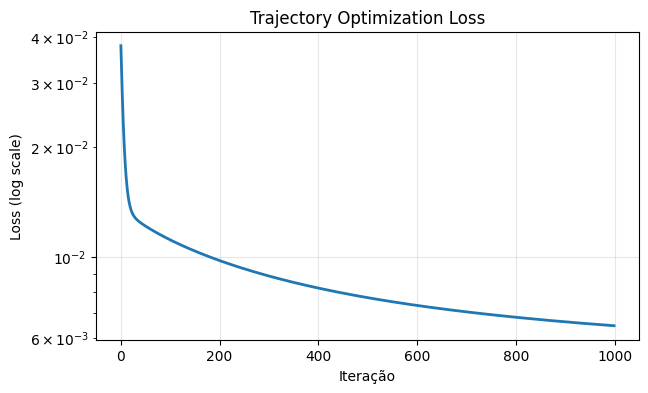

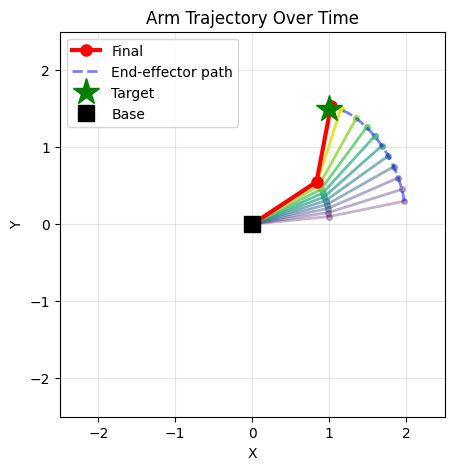

Trajectory Metrics:
  Total joint movement: 1.1832 radians
  Max velocity: 0.1116 rad/timestep
  Max acceleration: 0.0265 rad/timestep²
  Smoothness cost: 0.0018 (lower is better)


In [195]:
# Visualize results
plot_loss_curve(loss_hist, "Trajectory Optimization Loss")
plt.show()

plot_trajectory_sequence(theta_traj, LENGTHS, target)
plt.show()

analyze_trajectory_metrics(theta_traj)

<div class="alert alert-info">

Q12: Run trajectory optimization with three different energy weights: $\lambda_{energy} = [0.01, 0.1, 1.0]$ (keep $\lambda_{smooth}=0.05$ fixed). For each, visualize the resulting trajectory and report the total joint movement (sum of velocity magnitudes). How does increasing the energy penalty affect the motion? Does the arm still reach the target?
</div>


=== Running with lambda_energy = 0.01 ===
Iteration 100: Loss = 0.027457
Iteration 200: Loss = 0.011089
Iteration 300: Loss = 0.008149
Iteration 400: Loss = 0.006785
Iteration 500: Loss = 0.005958
Iteration 600: Loss = 0.005388
Iteration 700: Loss = 0.004966
Iteration 800: Loss = 0.004638
Iteration 900: Loss = 0.004373
Iteration 1000: Loss = 0.004154


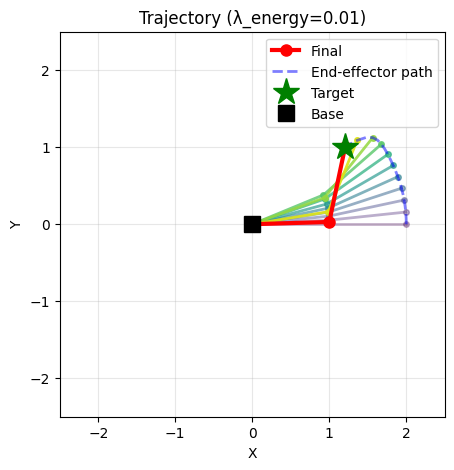

Total joint movement: 1.5943 rad
Distance to target: 0.0103

=== Running with lambda_energy = 0.1 ===
Iteration 100: Loss = 0.056746
Iteration 200: Loss = 0.034915
Iteration 300: Loss = 0.028075
Iteration 400: Loss = 0.024477
Iteration 500: Loss = 0.022159
Iteration 600: Loss = 0.020502
Iteration 700: Loss = 0.019242
Iteration 800: Loss = 0.018240
Iteration 900: Loss = 0.017420
Iteration 1000: Loss = 0.016732


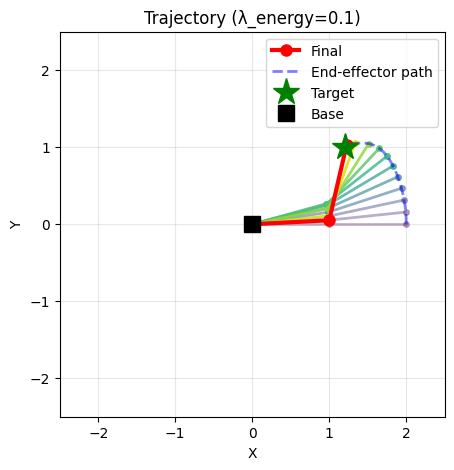

Total joint movement: 1.4190 rad
Distance to target: 0.0352

=== Running with lambda_energy = 1.0 ===
Iteration 100: Loss = 0.139589
Iteration 200: Loss = 0.123664
Iteration 300: Loss = 0.112564
Iteration 400: Loss = 0.104602
Iteration 500: Loss = 0.098815
Iteration 600: Loss = 0.094594
Iteration 700: Loss = 0.091525
Iteration 800: Loss = 0.089304
Iteration 900: Loss = 0.087706
Iteration 1000: Loss = 0.086561


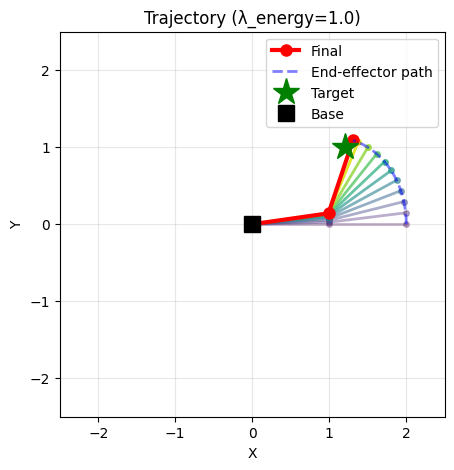

Total joint movement: 1.1197 rad
Distance to target: 0.1398


In [269]:
lambdas_energy = np.array([0.01, 0.1, 1.0])
lambda_smooth = 0.05
results = {}

LENGTHS = np.array([1.0, 1.0])
theta_init = np.array([0.0, 0.0])
target = np.array([1.2, 1.0])
T = 20

for lambda_e in lambdas_energy:
    print(f"\n=== Running with lambda_energy = {lambda_e} ===")
    theta_traj, loss_hist = gradient_descent_trajectory(
    theta_init, target, LENGTHS,
    T=T, learning_rate=0.05, n_iterations=1000,
    lambda_energy=lambda_e, lambda_smooth=lambda_smooth)

    results[lambda_e] = theta_traj

    plot_trajectory_sequence(theta_traj, LENGTHS, target, title=f"Trajectory (λ_energy={lambda_e})")
    plt.show()

    velocities = np.diff(theta_traj, axis=0)
    total_movement = np.sum(np.linalg.norm(velocities, axis=1))
    print(f"Total joint movement: {total_movement:.4f} rad")

    final_pos = forward_kinematics_numpy(theta_traj[-1], LENGTHS)
    dist_to_target = np.linalg.norm(final_pos - target)
    print(f"Distance to target: {dist_to_target:.4f}")

Increasing λ_energy makes movement more expensive, so the optimizer reduces total joint motion.

At λ_energy=1.0 the optimizer minimizes energy so strongly that the arm no longer reaches the target. Thus, there's a clear trade-off between energy efficiency and task completion.

<div class="alert alert-info">

Q13: Compare trajectory optimization using SGD with Momentum vs Adam. Use $T=20$, $\lambda_{energy}=0.1$, $\lambda_{smooth}=0.05$. Which converges faster? Plot both trajectories side-by-side. Do they find qualitatively different solutions (different motion strategies)?
</div>

Using the two functions created above after `gradient_descent_trajectory`:

In [196]:
theta_init = np.array([0.1, 0.1])
target = np.array([1.0, 1.5])
T = 20

print("Momentum")
theta_traj_m, loss_hist_m = momentum_trajectory(theta_init, target, LENGTHS,
                                                T=T, learning_rate=0.01, n_iterations=1000,
                                                lambda_energy=0.1, lambda_smooth=0.05)

print("="*60)
print("Adam")
theta_traj_a, loss_hist_a = adam_trajectory(theta_init, target, LENGTHS,
                                            T=T, learning_rate=0.01, n_iterations=1000,
                                            lambda_energy=0.1, lambda_smooth=0.05)

Momentum
Iteration 100: Loss = 0.006543
Iteration 200: Loss = 0.005656
Iteration 300: Loss = 0.005298
Iteration 400: Loss = 0.005092
Iteration 500: Loss = 0.004954
Iteration 600: Loss = 0.004854
Iteration 700: Loss = 0.004776
Iteration 800: Loss = 0.004714
Iteration 900: Loss = 0.004662
Iteration 1000: Loss = 0.004619
Adam
Iteration 100: Loss = 0.004451
Iteration 200: Loss = 0.004278
Iteration 300: Loss = 0.004278
Iteration 400: Loss = 0.004278
Iteration 500: Loss = 0.004278
Iteration 600: Loss = 0.004279
Iteration 700: Loss = 0.004281
Iteration 800: Loss = 0.004278
Iteration 900: Loss = 0.004279
Iteration 1000: Loss = 0.004278


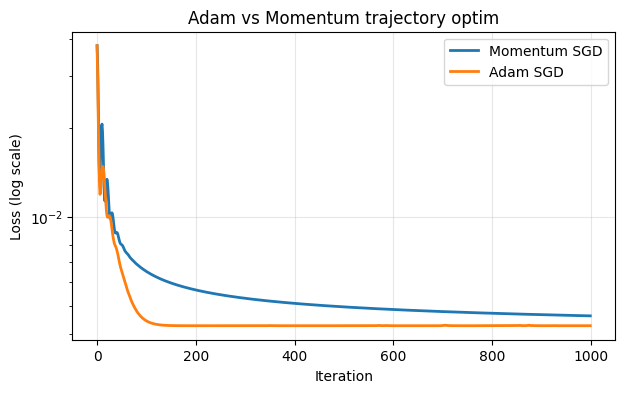

In [197]:
plt.figure(figsize=(7, 4))
plt.plot(loss_hist_m, linewidth=2, label="Momentum SGD")
plt.plot(loss_hist_a, linewidth=2, label="Adam SGD")
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.legend()
plt.title("Adam vs Momentum trajectory optim")
plt.grid(alpha=0.3)
plt.show()

We can see that Adam approach converges significantly faster.

Momentum


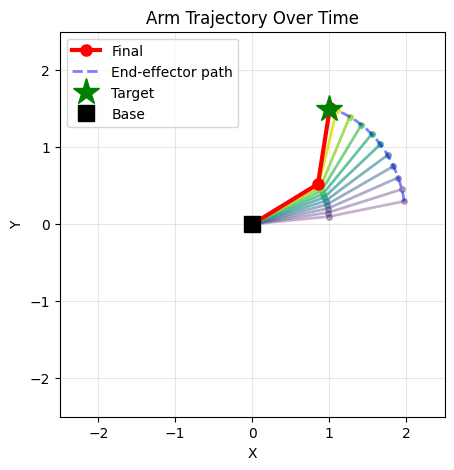

Adam


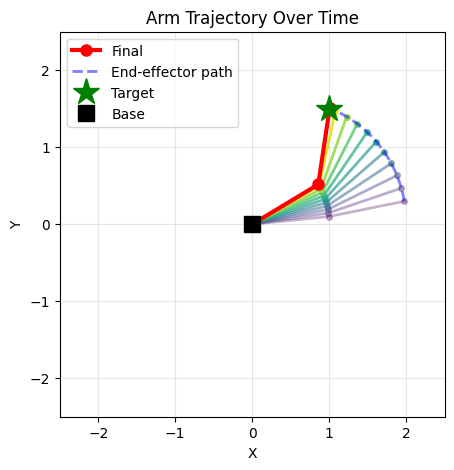

In [198]:
print("Momentum")
plot_trajectory_sequence(theta_traj_m, LENGTHS, target)
plt.show()

print("="*60)
print("Adam")
plot_trajectory_sequence(theta_traj_a, LENGTHS, target)
plt.show()

We see that both found the same motion strategy.

<div class="alert alert-info">

Q14: The trajectory optimization problem has $T \times 2$ parameters (40 parameters for $T=20$). This is similar to optimizing a small neural network. Based on your experiments, which optimizer (GD, Momentum, Adam) would you recommend for optimizing trajectories? How might your answer change if $T=100$ (200 parameters)?
</div>

For T = 20:
We use Momentum for faster convergence, or Adam if you want a more stable optimization with less sensitivity to hyperparameters.

For T = 100:
We use Adam, as it scales better with higher-dimensional problems and uneven gradient magnitudes across the trajectory.

<div class="alert alert-info">

Q15: Gradient-free methods can also optimize trajectories! However, with $T \times 2$ parameters, the search space becomes much larger. Implement ES for trajectory optimization. Use a smaller population size initially (N=10) and $T=10$ timesteps to keep computation manageable. Compare sample efficiency (total function evaluations) with Adam. When might ES be preferred despite being less sample-efficient?
</div>

In [236]:
def ES_trajectory(theta_init: np.ndarray,
                       target: np.ndarray,
                       lengths: np.ndarray,
                       alpha=0.1, sigma=0.1, N=30,
                       T: int = 20,
                       n_iterations: int = 1000,
                       lambda_energy: float = 0.1,
                       lambda_smooth: float = 0.05):
    
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    loss_fn = lambda seq: loss_trajectory(seq, lengths_jax, target_jax,
                                   lambda_energy, lambda_smooth)
    
    loss_history = []
    min_loss = np.inf
    
    for iteration in range(n_iterations):
        epsilons = np.random.randn(N,T,2)

        sequences = np.array([theta_sequence + sigma*eps for eps in epsilons])

        # Compute loss and weights
        losses = np.array([float(loss_fn(jnp.array(seq))) for seq in sequences])
        fitness = -losses
        weights_sum = np.sum(fitness[:, None] * epsilons, axis=0)
        
        # Update trajectory
        proposal = theta_sequence + alpha / N * weights_sum

        # Fix the first theta to be theta_init
        proposal = proposal.at[0].set(theta_init)
        loss_val = loss_fn(proposal)

        if loss_val < min_loss:
            theta_sequence = proposal
            min_loss = loss_val
        
        loss_history.append(float(min_loss))
        
        if (iteration + 1) % 100 == 0:
            print(f"Iteration {iteration + 1}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

In this case, we implemented the same ES as before but with a small twist: now we ensure that the new individual is better than the last best before updating the trajectory to avoid worsening the fitness as we saw in early tests.

In [244]:
theta_init = np.array([0.1, 0.1])
target = np.array([1.0, 1.5])
T = 10

print("ES")
theta_traj_es, loss_hist_es = ES_trajectory(theta_init, target, LENGTHS,
                                                T=T,alpha=0.1, sigma=0.1, N=10, 
                                                n_iterations=1000,
                                                lambda_energy=0.1, lambda_smooth=0.05)

print("="*60)
print("Adam")
theta_traj_a, loss_hist_a = adam_trajectory(theta_init, target, LENGTHS,
                                            T=T, learning_rate=0.01, n_iterations=1000,
                                            lambda_energy=0.1, lambda_smooth=0.05)

ES
Iteration 100: Loss = 0.014563
Iteration 200: Loss = 0.013711
Iteration 300: Loss = 0.011837
Iteration 400: Loss = 0.011512
Iteration 500: Loss = 0.010853
Iteration 600: Loss = 0.010370
Iteration 700: Loss = 0.010414
Iteration 800: Loss = 0.010089
Iteration 900: Loss = 0.010173
Iteration 1000: Loss = 0.009986
Adam
Iteration 100: Loss = 0.008957
Iteration 200: Loss = 0.008917
Iteration 300: Loss = 0.008917
Iteration 400: Loss = 0.008917
Iteration 500: Loss = 0.008917
Iteration 600: Loss = 0.008917
Iteration 700: Loss = 0.008917
Iteration 800: Loss = 0.008917
Iteration 900: Loss = 0.008917
Iteration 1000: Loss = 0.008917


ES


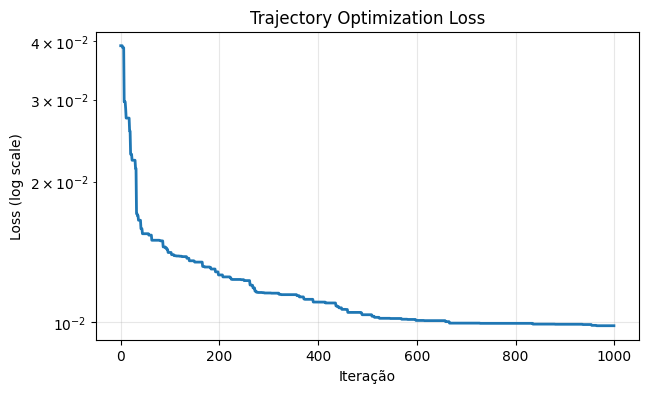

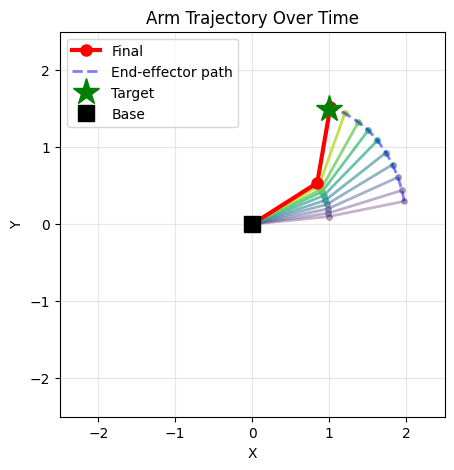

Adam


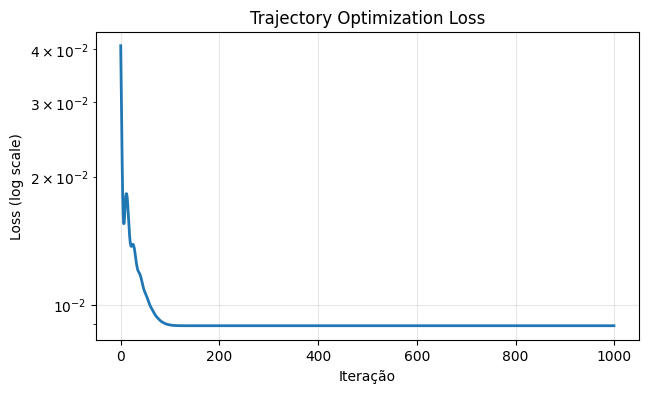

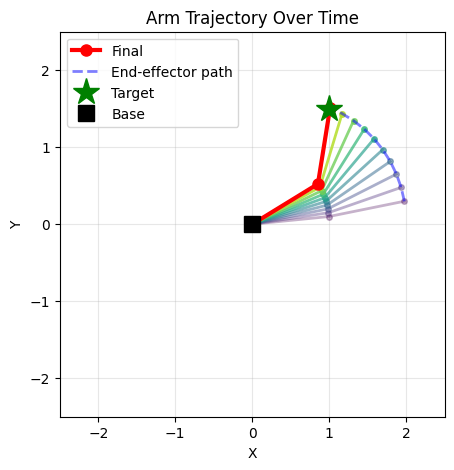

In [245]:
# Visualize results
print("ES")
plot_loss_curve(loss_hist_es, "Trajectory Optimization Loss", log=True)
plt.show()

plot_trajectory_sequence(theta_traj_es, LENGTHS, target)
plt.show()

print("Adam")
plot_loss_curve(loss_hist_a, "Trajectory Optimization Loss", log=True)
plt.show()

plot_trajectory_sequence(theta_traj_a, LENGTHS, target)
plt.show()

We see that the enlargement of the search space hinders the ES implementation, once, after three runs, it took 1000+, ~830 and ~630 iterations to converge, meaning and average of 8,200 evaluations, while the adam one took only ~100 iterations, each with a single loss function evaluation and gradient calculation, demonstrating a much higher sample-efficiency.

However, again, ES (or other gradient free optimization algorithms) are still preferred in cases where computing the gradient of the loss function is extremely more costly than evaluating it, or even outright impossible.